<div style="text-align: center;">
    <h1>Predicting Land Suitability for Native Trees in Brazil with Machine Learning </h1>
    <h2>Lucas Palomino</h2>
    <h3>December 16, 2024</h3>
</div>

---

# Abstract

Machine learning applications for ecological research are becoming increasingly common. By leveraging the cost-effectiveness and scalability of remotely sensed data, with the data processing capacities of GIS and machine learning, there are exciting opportunities to study land variables for tree suitability. Using publicly available data from governmental organizations, non-profit data providers, and independent contributors, I created a dataset combining environmental factors such as soil classifications, soil PH, and annual mean precipitation, among others, with native tree locations in Brazil. Upon creation of the dataset, different data pre-processing steps were carried out to train a decision tree and a multi-layer perceptron, including min-max normalization, one-hot encoding, label encoding, and train-test splits using Scikit Learn. Finally, the two models were trained and evaluated using performance metrics such as balanced/unbalanced accuracy, precision, recall, macro/micro f1 score, and AUC ROC. It was concluded that neither model performed well with the dataset to predict land suitability. Future improvements include considering other input features or limiting the problem to a binary decision problem.

# Introduction

In the face of global environmental challenges such as climate change and deforestation, there is an urgent need for sustainable land management and biodiversity conservation strategies. 

Field studies are costly and time-consuming, not to mention difficult to perform in remote areas for a country as large as Brazil. While field sampling is still needed for biological factors, one promising approach to addressing these challenges is the use of Geographic Information Systems (GIS) combined with Machine Learning (ML) to predict the suitability of land for the growth of native tree species. GIS provides the spatial data required to understand environmental variables such as soil type, temperature, rainfall, and slope, while ML algorithms can analyze this data to predict how well specific species of trees will thrive in various regions. 

This project aims to harness the power of GIS and ML to predict the suitability of native trees in Brazil, enabling more informed decisions for reforestation efforts, conservation, and sustainable land use planning. By applying satellite imagery, climate data, and soil characteristics, the project aims to create two models to identify the most suitable areas for planting native tree species.  

### Objectives: 

1. **Data Sourcing**: Utilize GIS to collect relevant geospatial data, including climate variables (temperature, precipitation), soil types, and topography. 

2. **Modeling Suitability**: Apply machine learning algorithms to build predictive models that assess the suitability of land for different native tree species in Brazil. 

3. **Evaluate Performance**: Calculate performance metrics to conclude whether or not the models are appropriate to provide insight about areas with optimal conditions for a particular tree. 


---

# Data Acquisition

A dataset containing 8 feature columns and 2585 sample points was created, compiling data from 40 different files using Excel and ArcGIS Pro. Below are the datasets used for the project.

- **USGS**: Brazil DEM (2010)
- **Restor** Soil PH (2016), Annual Mean Temperature (2017), Annual Mean Precipitation (2017)
- **IBGE**: Brazil Boundaries, Soil Classifications (2023)
- **Servicio Florestal Brasileiro** Tree inventory data (2020)
- **Luis Correia Antunes** Hydrological Resources of Brazil (2021)


### Data Processing

Excel and ArcGIS Pro were used to process and combine the files in different formats. The steps for each are outlined below.

##### Data Assumptions
- Census was taken by lot units, so coordinate locations were treated the same for trees recorded in the same lot
- Tree locations in urban areas were not considered due to being outliers
- Tree locations that appeared to grow in water, were changed to the nearest soil type
- The map projection used for the project was SIRGAS 2000.
- **Due to unclear name labels, especially for the Ipe tree, names were consolidated from 335 unique values to 7 name labels as follows**

|Label| Scientific Name | Common Name |
|-----| --------------- | ----------- |
|0| Bertholletia excelsa  | Castanheria |
|1| Caryocar brasiliense  | Pequi  |
|2| Handroanthus albus  | Ipê Branco  |
|3| Handroanthus chrysotrichus  | Ipê Amarelo |
|4| Handroanthus impetiginosus  | Ipê Rosa  |
|5| Tabebuia cassinoides  | Caixeta  |
|6| Tabebuia roseo-alba  | Ipê Rosa/Branco  |


Figure 1. Table of tree classifications

#### Excel

1) Open tree inventory data files, consisting of one .csv file for each tree category (Ipê, Castanheria, Pequi) and 37 study lot .csv (one for each state).
2) Apply the 'Text to Column' tool in Excel to separate values as columns, using commas as a delimeter.
3) Consolidate tree classes according to the following procedure:
   - Apply unique function to '_nome_campo_' (field name)
   - Count occurrences for each label
   - Remove rows with less than 10 occurrences per label
   - Combine remaining classes in major categories given by the top count values 
4) Join rows based on '_cong_' key (short for conglomerado = cluster)

#### ArcGIS Pro

1) **Load geospatial data**
   - Mean digital elevation models (.tif x5)
   - Soil PH raster (.tif)
   - Annual mean temperature (.tif)
   - Annual mean precipitation (.tif)
   - Brazil boundaries (.shp)
   - Soil classifications (.shp)
   - Hydrological resources (.kml)
   - Tree locations from the previous steps (.csv)
3) **Extract rivers layer**
    - Convert file from .kml to .shp 
    - Remove other geometries and keep major rivers only
4) **Generate slope layer**
   - Apply mosaic operation to merge all 5 digital elevation models, checking the box for pixel depth and using the blend then match mode
   - Use the extract by mask tool to limit the area to Brazil's boundaries
   - Calculate the slope from new combined DEM
5) **Unit conversion** (optional)
   - Convert annual mean temperature to degrees celsius using a raster calculator operation (raster * 0.1)
   - Obtain soil PH on a scale from 0-14 by using raster calculator operation (raster * 0.1)
   - Convert solar global horizontal irradiation from kWh/m2 to W/m² using raster calculator operation (raster * 41.67)
6) **Merge layers**
   -  Calculate tree proximity to river
   -  Drop unnecessary columns
   -  Extract point values from all raster layers, using tree points as the target feature
7) **Final data cleaning**
   - Drop unecessary columns
   - Remove ambiguous and duplicate data
   - Convert the final layer to .xlsx

<img src="CSCI%20498%20Workflow.jpg" alt="Image" width="1000">
Figure 2. Data workflow

## Data Preparation

After creating the dataset but before training the models, further data pre-processing was carried out using pandas and Sciki-learn. We start by importing needed libraries from Python and creating a dataframe from the Excel dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os

In [2]:
df_path = 'C:/Users/lukep/Documents/Classes/CSCI_498/FINAL_Dataframe.xlsx'
df = pd.read_excel(io=df_path, 
                   sheet_name='Processed_Dataframe', 
                   usecols='A:H', 
                   header=0, 
                   nrows=2585, 
                   engine='openpyxl' )

#### One Hot Encoding

Next, one hot encoding is applied to the soil classification column since both models require categorical variables to be converted into a numerical format before training. The one hot encoder creates a binary column for each soil type, assigning a value of 1 to the corresponding soil class and 0 to the rest. 

In [3]:
# Create one hot encoding object and extract column name
oh_encoder = OneHotEncoder(sparse_output=False)
soil_column = df[['soil_type']].columns.tolist()

# Apply one hot encoding to soil type column
encoded_soil = oh_encoder.fit_transform(df[soil_column])
df_encoded = pd.DataFrame(encoded_soil, columns=oh_encoder.get_feature_names_out(soil_column))

#### Min-Max Normalization

Min-max normalization scales the values of a feature to a range between 0 and 1. This is done to reduce model bias towards feature columns of large magnitudes such as solar irradiation. Min-max normalization will only be used for the multi-layer perceptron, since a decision tree evaluates each feature independently from others. 

In [4]:
# Extract numerical columns from dataframe and save column names
numerical_array = df.values[:,2:]
column_names = df.columns[2:].tolist()
df_numerical = pd.DataFrame(numerical_array, columns = column_names)

# Get column-wise max and min values
Xmax = df_numerical.max(axis=0)
Xmin = df_numerical.min(axis=0)

# Apply scaling and normalization
minmax_normalized = (df_numerical-Xmin)/(Xmax-Xmin)
df_normalized = pd.DataFrame(minmax_normalized, columns = column_names)

#### Label Encoder
Similarly, label encoder is used to convert the target column (scientific_name) into a numerical representation, so it can be fitted to the multi-Layer perceptron since it requires the target variable to be in a numerical format. The corresponding labels can be seen above in Figure 2.

In [5]:
# Create label encoder object and extract response column
lbl_encoder = LabelEncoder()
response_column = df['scientific_name']

# Apply label encoder to scientific name column
lbl_encoder.fit(response_column)
labeled_response = lbl_encoder.transform(response_column)
df_labeled = pd.DataFrame(labeled_response, columns=['scientific_name'])

#### Decision Tree Dataframe
We construct the decision tree dataframe by using the one hot encoded soil_column, and removing the original column for soil.

In [6]:
df_decision_tree = pd.concat([df, df_encoded], axis=1)
df_decision_tree = df_decision_tree.drop(soil_column, axis=1)
df_decision_tree

,scientific_name,river_distance,annual_precipitation,mean_annual_temp,soil_ph,slope,solar_irradiance,soil_type_AFLORAMENTOS DE ROCHAS,soil_type_ARGISSOLO,soil_type_CAMBISSOLO,...,soil_type_ESPODOSSOLO,soil_type_GLEISSOLO,soil_type_LATOSSOLO,soil_type_LUVISSOLO,soil_type_NEOSSOLO,soil_type_NITOSSOLO,soil_type_ORGANOSSOLO,soil_type_PLANOSSOLO,soil_type_PLINTOSSOLO,soil_type_VERTISSOLO
0,Handroanthus impetiginosus,2.534268,181.199997,20.4,4.5,0.757565,75004.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Handroanthus impetiginosus,6.069209,185.800003,20.5,4.5,0.838219,75338.796875,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Handroanthus impetiginosus,0.514618,186.100006,18.0,4.3,8.256320,72355.703125,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Handroanthus albus,1.399560,194.300003,19.1,4.2,1.940830,74745.296875,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Handroanthus albus,1.144493,135.100006,18.4,4.4,2.090570,68094.101562,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580,Bertholletia excelsa,12.092966,208.699997,25.4,3.7,0.703921,79737.398438,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2581,Bertholletia excelsa,1.507388,197.899994,25.5,4.0,0.175287,80133.101562,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2582,Bertholletia excelsa,4.355501,211.000000,25.6,3.8,1.015830,80087.500000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2583,Handroanthus impetiginosus,4.938685,260.000000,25.9,4.3,3.043080,82583.500000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Multi-Layer Perceptron Dataframe
Similarly, we construct the decision tree dataframe by using the one hot encoded soil_column, in addition to the normalized columns and the encoded tree name column.

In [7]:
df_multilayer_perceptron = pd.concat([df_labeled, df_normalized, df_encoded], axis=1)
df_multilayer_perceptron

,scientific_name,river_distance,annual_precipitation,mean_annual_temp,soil_ph,slope,solar_irradiance,soil_type_AFLORAMENTOS DE ROCHAS,soil_type_ARGISSOLO,soil_type_CAMBISSOLO,...,soil_type_ESPODOSSOLO,soil_type_GLEISSOLO,soil_type_LATOSSOLO,soil_type_LUVISSOLO,soil_type_NEOSSOLO,soil_type_NITOSSOLO,soil_type_ORGANOSSOLO,soil_type_PLANOSSOLO,soil_type_PLINTOSSOLO,soil_type_VERTISSOLO
0,4,0.075387,0.498413,0.319328,0.555555,0.028017,0.474989,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4,0.180583,0.519274,0.327731,0.555555,0.030999,0.484557,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.015284,0.520635,0.117647,0.444445,0.305338,0.399303,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.041619,0.557823,0.210084,0.388889,0.071776,0.467596,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2,0.034028,0.289342,0.15126,0.5,0.077314,0.277511,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580,0,0.359844,0.623129,0.739496,0.111111,0.026033,0.610265,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2581,0,0.044828,0.57415,0.747899,0.277778,0.006482,0.621574,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2582,0,0.129585,0.63356,0.756303,0.166667,0.037568,0.620271,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2583,4,0.14694,0.855782,0.781513,0.444445,0.11254,0.691604,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

# Model Building & Training

The two models selected for the analysis were a decision tree and a multi-layer perceptron. A decision tree (DT) is a non-parametric supervised learning model used for classification and regression problems. The model requires very little data pre-processing, and is considered a local optimizer/greedy algorithm. A multi-layer perceptron (MLP) is an artificial neural network that uses layers of connected nodes to transmit information one layer at a time. An MLP requires a greater degree of pre-processing, and is considered a global optimizer with a strong learning ability. 

We start by splitting the data into training and testing sets, followed by defining the model architectures, and then training the models with the provided data. 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

### Decision Tree

In [9]:
# Create numpy arrays for attribute and response variables
X_DT = df_decision_tree.values[:, 1:] 
y_DT = df_decision_tree.values[:, 0]

# Split data into train and test for both arrays 70:30
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.3, random_state=100)

In [10]:
# Create decision tree classifier object
DT_object = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=7, min_samples_leaf=3)

# Train decision tree using Gini index
DT_object.fit(X_train_DT, y_train_DT)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, random_state=100)

### Multi-Layer Perceptron

In [11]:
# Create numpy arrays for attribute and response variables
X_MLP = df_multilayer_perceptron.values[:, 1:].astype(float)
y_MLP = df_multilayer_perceptron.values[:, 0].astype(int)

# Split data into train and test for both arrays 70:30
X_train_MLP, X_test_MLP, y_train_MLP, y_test_MLP = train_test_split(X_MLP, y_MLP, test_size=0.3, random_state=100)

In [12]:
# Create multi-layer perceptron object with 1 hidden layer
MLP_object = MLPClassifier(hidden_layer_sizes=(30, 15),
                           activation='relu', 
                           solver='sgd', 
                           learning_rate_init=0.01, 
                           alpha=0.0001, 
                           batch_size='auto', 
                           max_iter=1000,
                           random_state=100)

MLP_object.fit(X_train_MLP, y_train_MLP)

MLPClassifier(hidden_layer_sizes=(30, 15), learning_rate_init=0.01,
              max_iter=1000, random_state=100, solver='sgd')

---

# Evaluating the Models


#### Confusion Matrix
A confusion matrix in a visual representation of the total number of predicted values for each class. The diagonal represents correct predictions.  

In [13]:
from sklearn.metrics import confusion_matrix

y_pred_DT = DT_object.predict(X_test_DT)
print("Decision Tree:\n", confusion_matrix(y_test_DT, y_pred_DT))

print('\n')

y_pred_MLP = MLP_object.predict(X_test_MLP)
print("Multi-Layer Perceptron:\n", confusion_matrix(y_test_MLP, y_pred_MLP))

Decision Tree:
 [[  4  18  20   0   0   0   0]
 [  2 303  30   0   2   3   8]
 [  3  85  57   0   8   0   9]
 [  0   8   3   0   0   0   0]
 [  2  46  22   0   7   0   2]
 [  0  11   8   0   0   1   2]
 [  2  73  18   0   6   1  12]]


Multi-Layer Perceptron:
 [[ 11  15  16   0   0   0   0]
 [  5 312  23   0   0   0   8]
 [  8  93  51   0   0   0  10]
 [  0   7   4   0   0   0   0]
 [  0  49  29   0   0   0   1]
 [  0  12  10   0   0   0   0]
 [  1  79  16   0   0   0  16]]


#### Accuracy

Accuracy refers to the ratio of total correct predicitons over total predictions. Since there is an uneven distribution of data points for each class, a balanced accuracy score was also computed to give weights to all classes equally regardless of frequency on the dataset.

<table border="0">
 <tr>
    <td>
        <b style="font-size:15px">$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$</b>
        $TP =$ True positives <br>
        $TN =$ True negatives <br>
        $FP =$ False positives <br>
        $FN =$ False negatives
    </td>
    <td>
        <b style="font-size:16px">$$B.Accuracy = \frac{\sum_{k=0}^{K}\frac{TP_k}{Total_k*w_k}}{W}$$</b>
        $TP_k =$ True positives in class k <br>
        $Total_k =$ Total predictions in class k <br>
        $w_k =$ Frequency of class in entire dataset 
    </td>
 </tr>
</table>

In [14]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

weights_DT = compute_sample_weight(class_weight="balanced", y=y_test_DT)
accuracy_DT = accuracy_score(y_test_DT, y_pred_DT) 
bal_acc_wgt_DT = balanced_accuracy_score(y_test_DT, y_pred_DT, sample_weight=weights_DT)

print("Decision Tree:")
print("Unbalanced Accuracy: ", round(accuracy_DT*100, 3), '%')
print("Balanced Accuracy Weighted:", round(bal_acc_wgt_DT*100, 3), '%')

print('\n')

weights_MLP = compute_sample_weight(class_weight="balanced", y=y_test_MLP)
accuracy_MLP = accuracy_score(y_test_MLP, y_pred_MLP)
bal_acc_wgt_MLP = balanced_accuracy_score(y_test_MLP, y_pred_MLP, sample_weight=weights_MLP)

print("Multi-Layer Perceptron:")
print("Unbalanced Accuracy: ", round(accuracy_MLP*100, 3), '%')
print("Balanced Accuracy Weighted:", round(bal_acc_wgt_MLP*100, 3), '%')


Decision Tree:
Unbalanced Accuracy:  49.485 %
Balanced Accuracy Weighted: 22.271 %


Multi-Layer Perceptron:
Unbalanced Accuracy:  50.258 %
Balanced Accuracy Weighted: 23.088 %


#### Precision & Recall
Precision measures the ratio of true positive predictions out of all the positive predictions made by the model, indicating the percentage of positives predictions that were actually correct. 
$$Precision = \frac{TP}{TP+FP}$$

Recall measures the proportion of true positive predictions out of all the actual positive instances, indicating the percetage of how well the model identified true positives.

$$Recall = \frac{TP}{TP+FN}$$

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_DT = precision_score(y_test_DT, y_pred_DT, average='weighted', zero_division=0.0)
recall_DT = recall_score(y_test_DT, y_pred_DT, average='weighted')

print("Decision Tree:")
print("Precision:", round(precision_DT*100, 3), '%')
print("Recall:", round(recall_DT*100, 3), '%')

print('\n')

precision_MLP = precision_score(y_test_MLP, y_pred_MLP, average='weighted', zero_division=0.0)
recall_MLP = recall_score(y_test_MLP, y_pred_MLP, average='weighted')

print("Multi-Layer Perceptron:")
print("Precision:", round(precision_MLP*100, 3), '%')
print("Recall:", round(recall_MLP*100, 3), '%')

Decision Tree:
Precision: 43.089 %
Recall: 49.485 %


Multi-Layer Perceptron:
Precision: 40.802 %
Recall: 50.258 %


#### Micro/Macro F1

The micro F1 score calculates the harmonic mean of precision and recall by aggregating true positives, false positives, and false negatives across all classes, treating each instance equally. The macro F1 score computes the F1 score for each class independently and takes their unweighted average, treating all classes equally regardless of size.

In [16]:
from sklearn.metrics import f1_score

micro_f1_DT = f1_score(y_test_DT, y_pred_DT, average="micro")
macro_f1_DT = f1_score(y_test_DT, y_pred_DT, average="macro")

print("Decision Tree:")
print(f"Micro F1 Score: {round((micro_f1_DT * 100), 2)}%") # Micro F1 = Regular Accuracy
print(f"Macro F1 Score: {round((macro_f1_DT * 100), 2)}%")

print('\n')

micro_f1_MLP = f1_score(y_test_MLP, y_pred_MLP, average="micro")
macro_f1_MLP = f1_score(y_test_MLP, y_pred_MLP, average="macro")

print("Multi-Layer Perceptron:")
print(f"Micro F1 Score: {round((micro_f1_MLP * 100), 2)}%") # Micro F1 = Regular Accuracy
print(f"Macro F1 Score: {round((macro_f1_MLP * 100), 2)}%")

Decision Tree:
Micro F1 Score: 49.48%
Macro F1 Score: 22.26%


Multi-Layer Perceptron:
Micro F1 Score: 50.26%
Macro F1 Score: 22.23%


#### ROC AUC

The area under the receiver operating curve is created by varying the decision threshold for predicting a positive class and measuring the resulting true positive ration (TPR) and false positive ratio (FPR). A ROC AUC that maximizes TPR increase, while minimizing FPR is considered ideal (steep rise, then flatten).

In [17]:
# Prepare data for ROC AUC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer # used for OVR analysis (different from OHE in that in requires all datatypes of cols to be the same )

# Turns repsonse labels [0-6] into binary array 
lbl_binarizer_DT = LabelBinarizer().fit(y_train_DT)
y_binarized_DT = lbl_binarizer_DT.transform(y_test_DT)

# Probabilities returned by model prediction
y_proba_DT = DT_object.predict_proba(X_test_DT)

lbl_binarizer_MLP = LabelBinarizer().fit(y_train_MLP)
y_binarized_MLP = lbl_binarizer_MLP.transform(y_test_MLP)
y_proba_MLP = MLP_object.predict_proba(X_test_MLP)

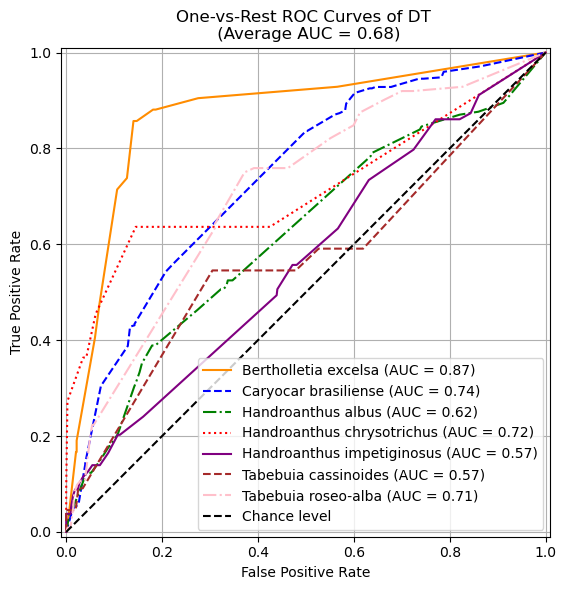

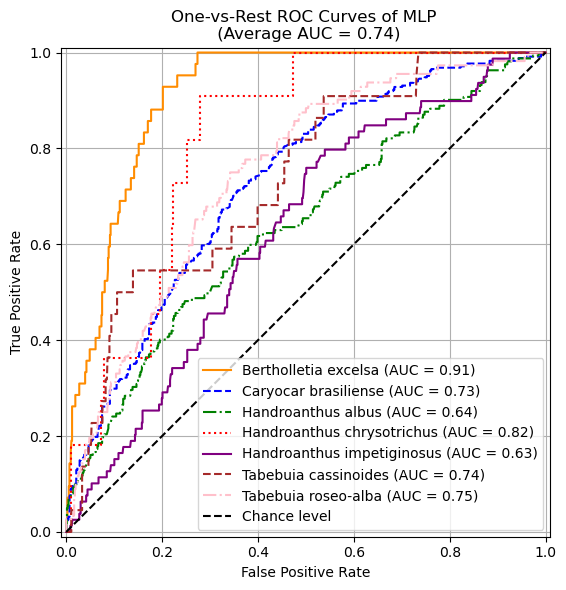

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

def Create_ROC_Graph(model_name, y_binarized, y_proba, y_test):
    
    class_labels = [0,1,2,3,4,5,6]  # Number of classes
    class_names = lbl_encoder.inverse_transform(class_labels)
    colors = cycle(["darkorange", "blue", "green", "red", "purple", "brown", "pink"])
    line_styles = cycle(["-", "--", "-.", ":"])
    
    # Create a single plot
    figure, axis = plt.subplots(figsize=(6, 6))  # Create a shared axis
    
    # Loop through the classes, limiting to n_classes
    for i, (color, line_style) in zip(class_labels, zip(colors, line_styles)):
        RocCurveDisplay.from_predictions(
            y_binarized[:, i],
            y_proba[:, i],
            name=f"{class_names[i]}",
            color=color,
            linestyle=line_style,
            plot_chance_level=False,
            ax=axis,  # Use the same axis for all plots
        )

    total_roc_auc_score = round(roc_auc_score(y_test, y_proba, multi_class='ovr'),2)
    
    axis.plot([0, 1], [0, 1], "k--", label="Chance level")
    axis.set_title(f"One-vs-Rest ROC Curves of {model_name} \n (Average AUC = {str(total_roc_auc_score)})")
    axis.set_xlabel("False Positive Rate")
    axis.set_ylabel("True Positive Rate")
    axis.legend(loc="lower right")
    axis.grid()
    
    plt.tight_layout()
    plt.show()

Create_ROC_Graph("DT", y_binarized_DT, y_proba_DT, y_test_DT)
Create_ROC_Graph("MLP", y_binarized_MLP, y_proba_MLP, y_test_MLP)

## Conclusion

#### Discussion
Currently, neither model is able to predict land suitability for native trees in Brazil reliably. While the multi-layer perceptron performed slightly better than the decision tree, the issue lies in the feature columns being too similar providing no differentiators for the models to capture. The problem can stem from trees species growing under very similar conditions, especially for trees in the same genus (eg. Handroanthus albus/chrysotrichus/impetiginosus), or a flawed classification of the initial classes. One exception to this behavior was predicting bertholletia excelsa. It was observed from the AUC ROC, that both models performed quite well at predicting bertholletia excelsa, with values of 0.84 and 0.91 respectively. This was interesting since it had 163 samples from the original dataset, which was lower than most other classes.

#### Future Improvements
In order to refine the predictions, a few improvements came from the completion of the project:
- Consult with a forestry expert about tree types
- Consider other input features (organic carbon, urban proximity) 
- Frame the question as a binary classification problem for a specific tree species


## Sources

[1] Yousefi, S. Avand, M. Yariyan, P. (November, 2021) Identification of the most suitable afforestation sites by Juniperus excels specie using maching learning models: Firuzkuh semi-arid region, Iran. Ecological Informatics.

[2] Silva, J. Eleto, C. Villanova, P. et al. (March 2024) Machine learning methods: Modeling net growth in the Atlantic Forest of Brazil. Ecological Informatics.

[3] Grandini, M. Bagli, E. Visani, G. (August 14, 2020) Metrics for Multi-Class Classification: An Overview. CRIF

[4]: Scikit Learn - Decision Trees: https://scikit-learn.org/1.5/modules/tree.html

[5] Andreoni, M. (Nov. 9, 2023) Deforestation in the Brazilian Amazon Falls to a Five-Year Low. New York Times https://www.nytimes.com/2023/11/09/climate/amazon-deforestation.html
